In [1]:
from execution import AC, TWAP, GLOBE
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import OnlineData


In [2]:
def calc_ACPR(  T: int,
                W: np.ndarray, 
                strategy: str,
                start: int, 
                stop: int, 
                num: int,  
                file1: str, #ask
                file2: str, #bid
                rounds_for_est: int,
                skip: int = 0, 
                **params) -> np.ndarray:

    ELL = np.linspace(start = start, stop = stop, num = num, endpoint = True, dtype = int)
    ACPR = []
    if strategy == 'GLOBE':

        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            args = {'T': T, 'W': W, 'L': L, **params}
            
            globe = GLOBE(**args)
            globe.estimate_parameters(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=rounds_for_est + W.shape[0] + 1)
            globe.Mr = globe.M
            # print(len(globe.M))

            orderbook_ask.close()
            orderbook_bid.close()

            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            ACPR_globe = globe.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=rounds_for_est)
            orderbook_ask.close()
            orderbook_bid.close()
            ACPR.append(ACPR_globe)

        ACPR = np.array(ACPR)
    if strategy == 'TWAP':
        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)


            twap = TWAP(T, L , W)
            ACPR_twap = twap.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, skip_rounds=rounds_for_est)
            orderbook_ask.close()
            orderbook_bid.close()
            ACPR.append(ACPR_twap)

        ACPR = np.array(ACPR)

    if strategy == 'AC':
        for L in tqdm(ELL):
            orderbook_bid = OnlineData(file2)
            orderbook_ask = OnlineData(file1)

            for _ in range(skip):
                next(orderbook_bid)
                next(orderbook_ask)

            args = {'T': T, 'W': W, 'L': L, **params}
            ac = AC(**args)
            ACPR_ac = ac.cumulative_impact(orderbook_bid=orderbook_bid, orderbook_ask=orderbook_ask, rounds_for_est=15)
            ACPR.append(ACPR_ac)
            orderbook_ask.close()
            orderbook_bid.close()
        ACPR = np.array(ACPR) 
    return ACPR


def plot_ACPR(start, stop, num, ACPR, legends, filename):
    ELL = np.linspace(start = start, stop = stop, num = num, endpoint = True, dtype = int)
    sns.set(rc = {"figure.figsize":(16, 9)})
    for acpr, legend in zip(ACPR, legends):
        plt.plot(ELL, acpr,'-', label = legend)

    plt.xlabel('L')
    plt.ylabel(f'ACPR')
    plt.grid(True)
    plt.legend()
    plt.savefig(filename)
    plt.show()

def calc_all(
                T: int, 
                W: np.ndarray, 
                start: int, 
                stop: int, 
                num: int, 
                file1: str, 
                file2: str, 
                rounds_for_est: int, 
                skip: int = 0, 
                strategies: list = ['TWAP', 'AC', 'GLOBE'],
                **params) -> list:
    
    ACPR = []
    for strategy in strategies:
        
        ACPR.append(calc_ACPR(T = T, W = W, strategy = strategy, 
                              start = start, stop = stop, num = num, skip = skip, 
                              file1 = file1, file2 = file2, rounds_for_est = rounds_for_est, **params[strategy]))
    return ACPR

def calc_and_plot_all(
                        T: int, 
                        W: np.ndarray, 
                        start: int, 
                        stop: int, 
                        num: int, 
                        file1: str, 
                        file2: str, 
                        rounds_for_est: int, 
                        skip: int = 0, 
                        strategies: list = ['TWAP', 'AC', 'GLOBE'],
                        filename: str = 'TWAP_AC_GLOBE.pdf',
                        **params) -> list:
    
    ACPR = calc_all(T, W, start, stop, num, file1, file2, rounds_for_est, skip, strategies, **params)
    legends = strategies
    plot_ACPR(start, stop, num, ACPR, legends, filename)  

def parser_N(file1, file2, filename1, filename2, skip = 10, MAX_ITER = 10_000, N = 100):

    f1 = open(file1, 'r')
    f2 = open(file2, 'r')

    f3 = open(filename1, 'w')
    f4 = open(filename2, 'w')

    for _ in range(skip):
        line_ask = f1.readline()
        line_bid = f2.readline()

    if line_ask != '' and line_bid != '': 
        f3.write(line_ask)
        f4.write(line_bid)

        for _ in tqdm(range(MAX_ITER)):
            for s in range(N):
                line_ask = f1.readline()
                line_bid = f2.readline()
            if line_ask == '' or line_bid == '':
                break
            f3.write(line_ask)
            f4.write(line_bid)

    f1.close()
    f2.close()
    f3.close()
    f4.close()

In [3]:
file1 = 'ask1s.tsv'
file2 = 'bid1s.tsv'
T = 50
W = np.ones(shape = 10, dtype = int) * 500

W_max = 501 #only for GLOBE

lamb = 2*(0.01)
eta = 2*(0.001)
init_sigma = 0.021713089727230926

start = 2
stop = T
num = 49

skip = 0
rounds_for_est = 15

K = 100000.



params_GLOBE = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma, 'W_max': W_max, 'K': K}
params_AC = {'lamb': lamb, 'eta': eta, 'init_sigma': init_sigma}
params_TWAP = {}

default_params = {'T': T, 'W': W, 'start': start, 'stop': stop, 'num': num,
                   'skip': skip, 'rounds_for_est': rounds_for_est, 'file1': file1, 'file2': file2}
params = {'TWAP': params_TWAP, 'AC': params_AC, 'GLOBE': params_GLOBE}

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [01:23<00:00,  1.70s/it]


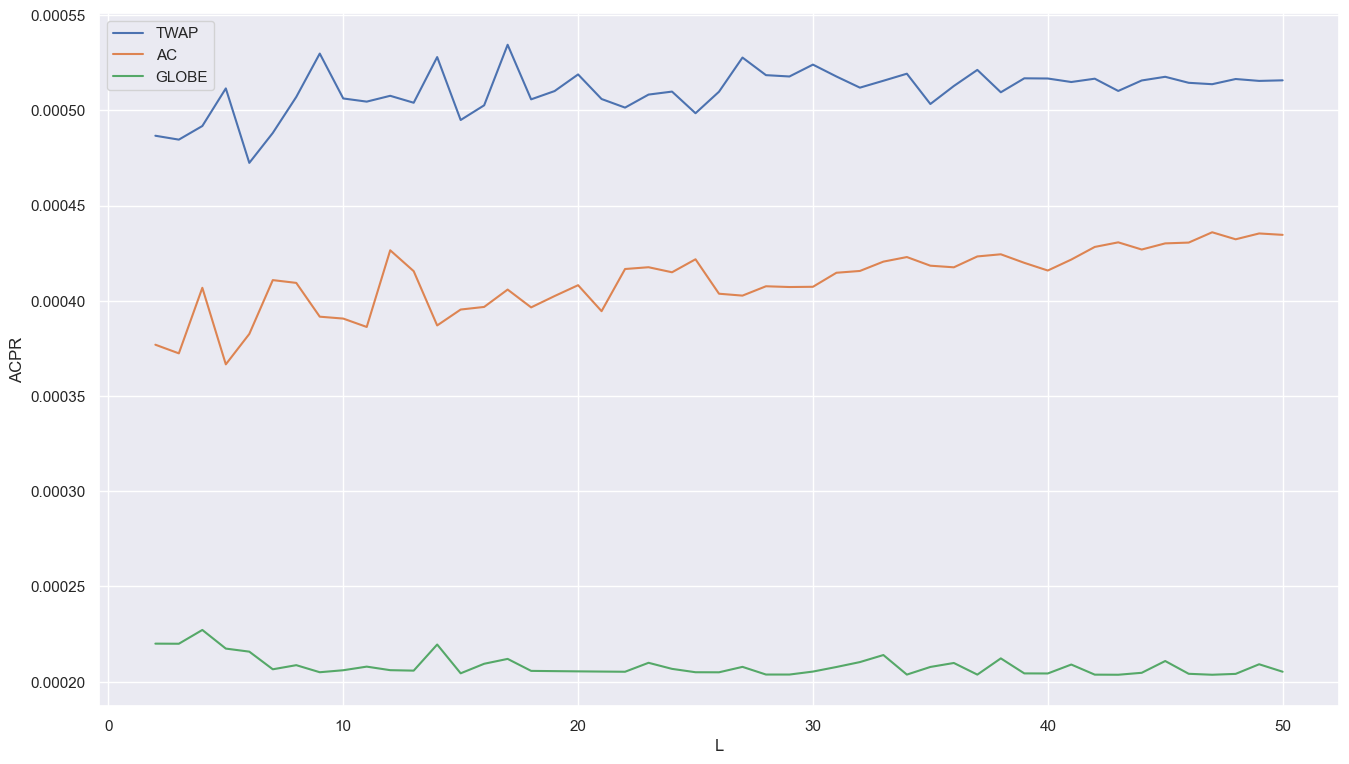

In [4]:
calc_and_plot_all(**default_params, **params)